# 🌲 RandomForest – Leakage check + CV + Noise + Training
Flow:
1) Load dữ liệu & chuẩn hóa tên cột
2) EDA nhanh
3) Chuẩn bị features/label (numeric/categorical)
4) Train/Test split + kiểm tra trùng mẫu (leakage)
5) Stratified K-Fold Cross-Validation (Pipeline OneHot + RF)
6) (Tuỳ chọn) Thêm feature noise + label noise
7) GridSearchCV → lưu pipeline & label encoder, log CSV, confusion matrix

## 1) Load dữ liệu

In [24]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import joblib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer


In [25]:
import sklearn
print(sklearn.__version__)

1.6.1


In [26]:
# Load dữ liệu
DATA_PATH = "../Recommend_size/datanew.csv"
df = pd.read_csv(DATA_PATH)
print("✅ Đã đọc:", DATA_PATH)
df.head()


✅ Đã đọc: ../Recommend_size/datanew.csv


,height,weight,gender,chest,waist,shoulder,size
0,1.81,75,Nam,120,120,55,XL
1,1.56,46,Nam,98,101,49,XS
2,1.63,81,Nam,115,114,55,L
3,1.67,85,Nữ,122,118,55,XL
4,1.65,88,Nam,112,116,54,L


## 2) EDA nhanh

,height,weight,gender,chest,waist,shoulder,size,BMI
count,699.000000,699.000000,699,699.000000,699.000000,699.000000,699,699.000000
unique,NaN,NaN,2,NaN,NaN,NaN,6,NaN
top,NaN,NaN,Nam,NaN,NaN,NaN,XL,NaN
freq,NaN,NaN,359,NaN,NaN,NaN,203,NaN
mean,1.701359,73.507868,NaN,116.387697,116.261803,54.672389,NaN,256125.324484
std,0.108035,18.697513,NaN,8.083725,7.999023,2.947967,NaN,69979.898860
min,1.480000,40.000000,NaN,98.000000,98.000000,47.000000,NaN,119442.204903
25%,1.610000,58.000000,NaN,109.000000,109.000000,53.000000,NaN,197706.591379
50%,1.700000,74.000000,NaN,118.000000,118.000000,55.000000,NaN,251531.502292
75%,1.790000,88.000000,NaN,122.000000,122.000000,57.000000,NaN,304823.118030


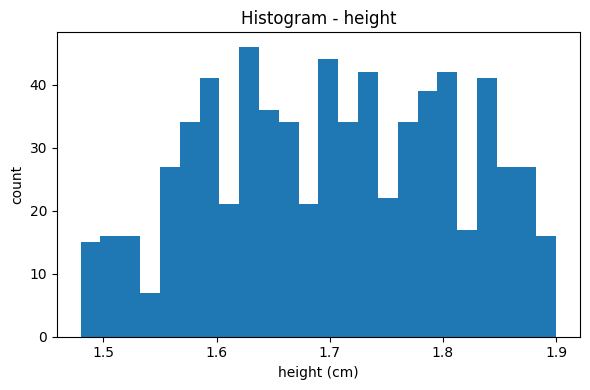

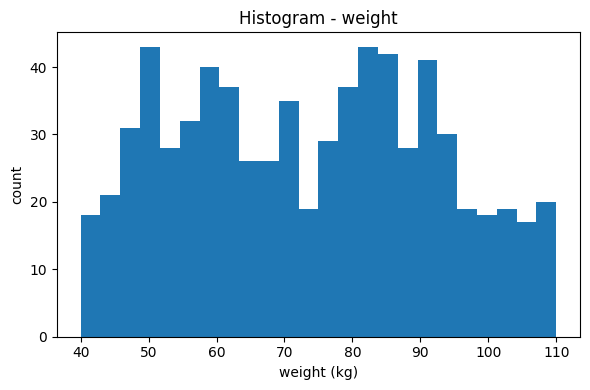

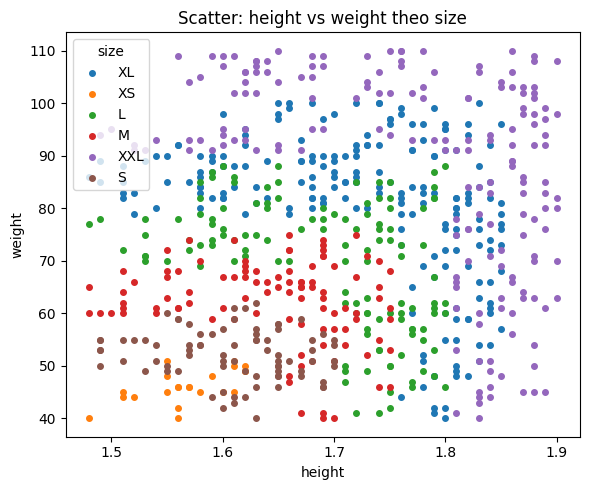

In [27]:

assert "size" in df.columns, "Thiếu cột nhãn 'size'."
if "height" in df.columns and "weight" in df.columns and "BMI" not in df.columns:
    df["BMI"] = df["weight"] / ((df["height"]/100.0)**2)

display(df.describe(include="all"))

# Histogram height/weight (nếu có)
if "height" in df.columns:
    plt.figure(figsize=(6,4)); plt.hist(df["height"].dropna(), bins=24)
    plt.title("Histogram - height"); plt.xlabel("height (cm)"); plt.ylabel("count"); plt.tight_layout(); plt.show()
if "weight" in df.columns:
    plt.figure(figsize=(6,4)); plt.hist(df["weight"].dropna(), bins=24)
    plt.title("Histogram - weight"); plt.xlabel("weight (kg)"); plt.ylabel("count"); plt.tight_layout(); plt.show()

# Scatter height vs weight theo size
if all(c in df.columns for c in ["height","weight","size"]):
    plt.figure(figsize=(6,5))
    for s in df["size"].unique():
        sub = df[df["size"]==s]
        plt.scatter(sub["height"], sub["weight"], s=16, label=str(s))
    plt.title("Scatter: height vs weight theo size"); plt.xlabel("height"); plt.ylabel("weight")
    plt.legend(title="size"); plt.tight_layout(); plt.show()


## 3) Chuẩn bị features/label, tách numeric & categorical

In [28]:

feature_cols = [c for c in df.columns if c != "size"]
feature_cols = [c for c in feature_cols if not df[c].isna().all()]
df_use = df[feature_cols + ["size"]].dropna().copy()

# Ép kiểu số nếu có thể
for c in feature_cols:
    if df_use[c].dtype == object:
        try:
            df_use[c] = pd.to_numeric(df_use[c])
        except Exception:
            pass

cat_cols = [c for c in feature_cols if df_use[c].dtype == object]
num_cols = [c for c in feature_cols if c not in cat_cols]

print("Numeric features:", num_cols)
print("Categorical features:", cat_cols)

le = LabelEncoder()
y = le.fit_transform(df_use["size"])
X = df_use[feature_cols]


Numeric features: ['height', 'weight', 'chest', 'waist', 'shoulder', 'BMI']
Categorical features: ['gender']


## 4) Train/Test split + kiểm tra trùng mẫu (leakage)

In [29]:


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape, " | Test:", X_test.shape)

# Kiểm tra bản ghi trùng giữa train/test
train_df = X_train.copy(); test_df = X_test.copy()
for c in feature_cols:
    if train_df[c].dtype == object:
        train_df[c] = train_df[c].astype(str)
        test_df[c] = test_df[c].astype(str)

dup = train_df.merge(test_df, on=feature_cols, how="inner")
print(f"⚠️ Số bản ghi trùng giữa train/test: {len(dup)}")


Train: (559, 7)  | Test: (140, 7)
⚠️ Số bản ghi trùng giữa train/test: 0


## 5) Stratified K-Fold CV với Pipeline (OneHot + RF)

In [30]:

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols),
])
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
pipe = Pipeline([("prep", preprocess), ("rf", rf)])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
print("CV scores:", cv_scores, " | Mean:", round(cv_scores.mean(), 4))


CV scores: [1. 1. 1. 1. 1.]  | Mean: 1.0


## 6) (Tuỳ chọn) Thêm noise (feature + label)

In [31]:

ADD_FEATURE_NOISE = True
ADD_LABEL_NOISE   = True
rng = np.random.default_rng(42)

X_aug = X.copy().reset_index(drop=True)
y_aug = y.copy()

# Feature noise
if ADD_FEATURE_NOISE and len(num_cols) > 0:
    ratios = {"height":0.005,"weight":0.01,"chest":0.01,"waist":0.01,"shoulder":0.01,"BMI":0.015}
    for c in num_cols:
        r = ratios.get(c, 0.008)
        std = (X_aug[c].astype(float).abs() + 1e-6) * r
        X_aug[c] = X_aug[c].astype(float) + rng.normal(0, std)
    if "height" in X_aug.columns: X_aug["height"] = X_aug["height"].clip(120, 220)
    if "weight" in X_aug.columns: X_aug["weight"] = X_aug["weight"].clip(30, 200)

# Label noise 2%
if ADD_LABEL_NOISE:
    rate = 0.02
    nflip = int(len(y_aug)*rate)
    idxs = rng.choice(len(y_aug), size=nflip, replace=False)
    labels = np.unique(y_aug)
    for i in idxs:
        cur = y_aug[i]
        choices = labels[labels != cur]
        y_aug[i] = rng.choice(choices)
    print(f"Đã thêm label noise: {nflip} mẫu (~{rate*100:.1f}%).")


Đã thêm label noise: 13 mẫu (~2.0%).


## 7) GridSearchCV + lưu pipeline, label encoder, log CSV, confusion matrix

Best params: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 400}
Best CV accuracy: 0.9624
Test accuracy: 0.9643 | F1-macro: 0.9304

Classification report:
              precision    recall  f1-score   support

           L       0.93      1.00      0.96        25
           M       1.00      0.95      0.97        20
           S       0.94      0.94      0.94        16
          XL       0.97      1.00      0.99        39
          XS       1.00      0.60      0.75         5
         XXL       0.97      0.97      0.97        35

    accuracy                           0.96       140
   macro avg       0.97      0.91      0.93       140
weighted avg       0.97      0.96      0.96       140

✅ Saved pipeline & label encoder.
✅ Saved rf_full_training_log.csv


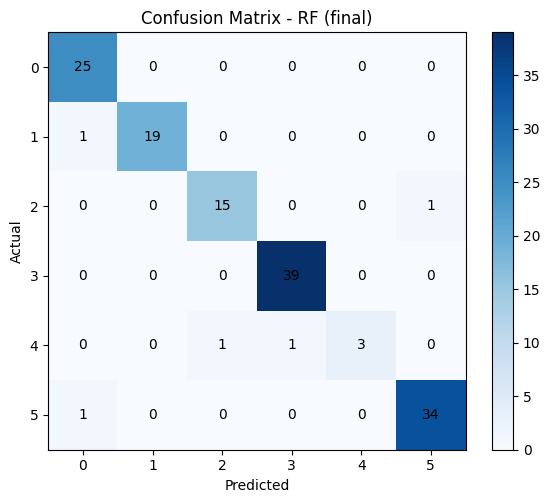

✅ Saved rf_full_confusion_matrix.png


In [32]:

X_tr, X_te, y_tr, y_te = train_test_split(
    X_aug, y_aug, test_size=0.2, random_state=42, stratify=y_aug
)

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols),
])

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
pipe = Pipeline([("prep", preprocess), ("rf", rf)])

param_grid = {
    "rf__n_estimators": [200, 400],
    "rf__max_depth": [None, 10, 16],
    "rf__min_samples_split": [2, 4],
    "rf__min_samples_leaf": [1, 2],
    "rf__max_features": ["sqrt", "log2", None],
}

gs = GridSearchCV(pipe, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
gs.fit(X_tr, y_tr)

best_pipe = gs.best_estimator_
print("Best params:", gs.best_params_)
print("Best CV accuracy:", round(gs.best_score_, 4))

# Test
y_pred = best_pipe.predict(X_te)
acc = accuracy_score(y_te, y_pred)
f1m = f1_score(y_te, y_pred, average="macro")
print("Test accuracy:", round(acc,4), "| F1-macro:", round(f1m,4))

labels_sorted = np.unique(y_te)
target_names  = le.inverse_transform(labels_sorted)
print("\nClassification report:")
print(classification_report(y_te, y_pred, labels=labels_sorted, target_names=target_names))

# Save artifacts
OUT_DIR = "."
joblib.dump(best_pipe, os.path.join(OUT_DIR, "rf_full_pipeline.pkl"))
joblib.dump(le,        os.path.join(OUT_DIR, "rf_full_label_encoder.pkl"))
print("✅ Saved pipeline & label encoder.")

# Log CSV
rep_dict = classification_report(y_te, y_pred, output_dict=True, labels=labels_sorted, target_names=target_names)
log_df = pd.DataFrame(rep_dict).transpose().reset_index().rename(columns={"index":"label"})
log_df.insert(1, "acc_overall", acc); log_df.insert(2, "f1_macro_overall", f1m)
log_df.to_csv(os.path.join(OUT_DIR, "rf_full_training_log.csv"), index=False)
print("✅ Saved rf_full_training_log.csv")

# Confusion matrix (save ảnh)
cm = confusion_matrix(y_te, y_pred, labels=labels_sorted)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix - RF (final)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
for (i,j),v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.colorbar(); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "rf_full_confusion_matrix.png"), dpi=150)
plt.show()
print("✅ Saved rf_full_confusion_matrix.png")
